In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import os
import gc

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# LOADING DATA

In [2]:
foldernames = os.listdir('data/oregon_wildlife/')
categories = []
files = []

for k, folder in enumerate(foldernames):
    filenames = os.listdir("data/oregon_wildlife/" + folder);
    for file in filenames:
        files.append("data/oregon_wildlife/" + folder + "/" + file)
        categories.append(folder)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories})

In [3]:
from sklearn.model_selection import train_test_split

train_dataframe, val_dataframe = train_test_split(df, test_size=0.33, random_state=42, stratify=df['category'])

In [5]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = val_datagen.flow_from_dataframe(dataframe=val_dataframe,
                                                    directory = None,
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode='categorical')

Found 9346 validated image filenames belonging to 20 classes.
Found 4608 validated image filenames belonging to 20 classes.


/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 42 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 17 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# PREPPING MODEL PREDICTIONS

In [6]:
ground_truth = validation_generator.classes

In [9]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model('models/model.h5')

predictions = model.predict_generator(validation_generator)

W0505 10:13:30.037253 4459965888 deprecation.py:323] From <ipython-input-9-8da20b505d12>:7: Model.predict_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.predict, which supports generators.
/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +
/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 85 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (size, len(data), tag))
/Users/alex.nim@ibm.com/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 93 bytes but only got 0. Skipping tag 33285
  " Skipping tag %s" % (si

make a dictionary storing the image index to the prediction and ground truth

In [15]:
prediction_index = []
for prediction in predictions:
    prediction_index.append(np.argmax(prediction))

In [16]:
def accuracy(predictions, ground_truth):
    total = 0
    for i, j in zip(predictions, ground_truth):
        if i == j:
            total += 1
    return total * 1.0 / len(predictions)

In [17]:
print(accuracy(prediction_index, ground_truth))

0.5861545138888888


# ANALYSIS FUNCTIONS

In [18]:
def get_images_with_sorted_probabilities(prediction_table,
                                         get_highest_probability,
                                         label,
                                         number_of_items,
                                         only_false_predictions=False):
    sorted_prediction_table = [(k, prediction_table[k])
                               for k in sorted(prediction_table,
                                               key=prediction_table.get,
                                               reverse=get_highest_probability)
                               ]
    result = []
    for index, key in enumerate(sorted_prediction_table):
        image_index, [probability, predicted_index, gt] = key
        if predicted_index == label:
            if only_false_predictions == True:
                if predicted_index != gt:
                    result.append(
                        [image_index, [probability, predicted_index, gt]])
            else:
                result.append(
                    [image_index, [probability, predicted_index, gt]])
    return result[:number_of_items]

In [50]:
def plot_images(filenames, distances, message):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 15))
    columns = 5
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        ax.set_title("\n\n" + filenames[i].split("/")[-1] + "\n" +
                     "\nProbability: " +
                     str(float("{0:.2f}".format(distances[i]))))
        plt.suptitle(message, fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.imshow(image)
        
def display(sorted_indices, message):
    similar_image_paths = []
    distances = []
    for name, value in sorted_indices:
        [probability, predicted_index, gt] = value
#        similar_image_paths.append(VALIDATION_DATA_DIR + filenames[name])
        similar_image_paths.append(df.loc[name]['filename'])
        distances.append(probability)
    plot_images(similar_image_paths, distances, message)

# ANALYSIS

In [10]:
# prediction_table is a dict with index, prediction, ground truth
prediction_table = {}
for index, val in enumerate(predictions):
    index_of_highest_probability = np.argmax(val)
    value_of_highest_probability = val[index_of_highest_probability]
    prediction_table[index] = [value_of_highest_probability,
index_of_highest_probability, ground_truth[index]]
assert len(predictions) == len(ground_truth) == len(prediction_table)

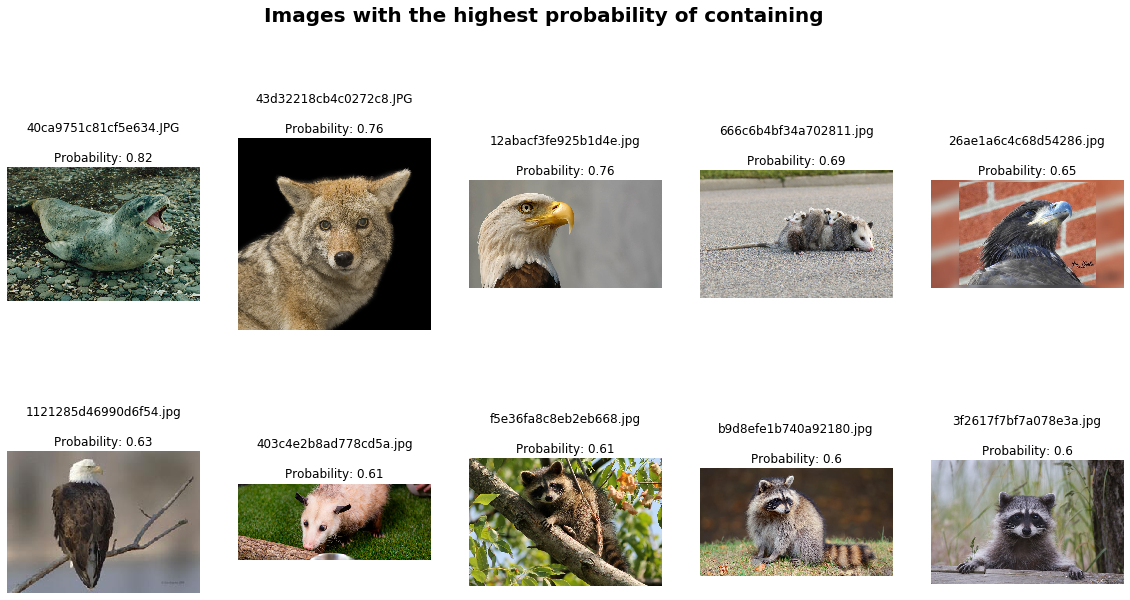

In [56]:
indices = get_images_with_sorted_probabilities(prediction_table,
                                get_highest_probability=True, label=12, number_of_items=10,
                                only_false_predictions=False)
message = 'Images with the highest probability of containing '
display(indices[:10], message)

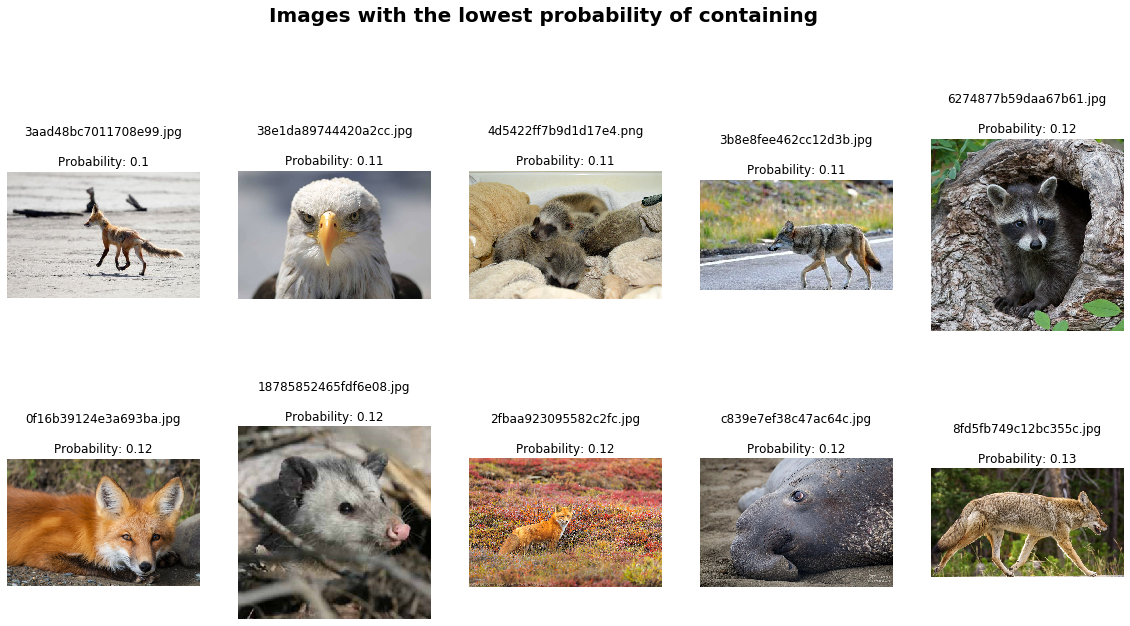

In [59]:
indices = get_images_with_sorted_probabilities(prediction_table,
get_highest_probability=False, label=1, number_of_items=10,
only_false_predictions=False)
message = 'Images with the lowest probability of containing '
display(indices[:10], message)

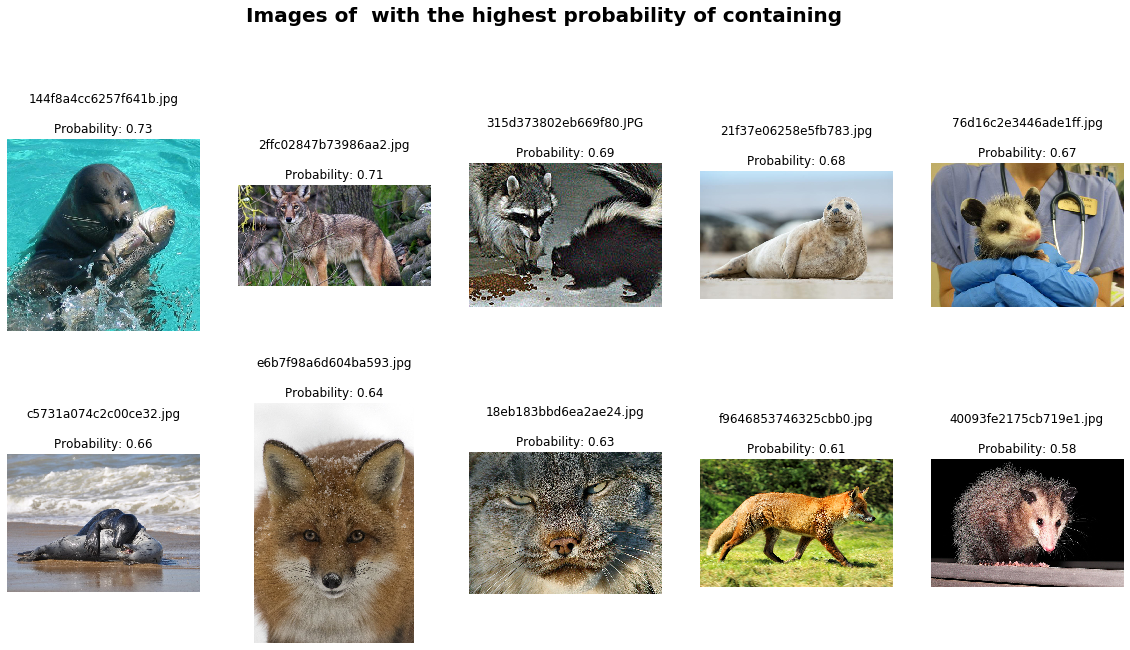

In [63]:
# Incorrect predictions of 'cat'
indices = get_images_with_sorted_probabilities(prediction_table,
get_highest_probability=True, label=0, number_of_items=10,
only_false_predictions=True)
message = 'Images of  with the highest probability of containing '
display(indices[:10], message)